# E2E Pipeline for Predictive Analytics

This worksheet illustrates an end to end pipeline used for solving general machine learning tasks. It includes (but is not restricted to) various techniques in the following key stages: 
- Data preparation
- Understanding the data
- Data preprocessing
- Model training
- Testing model generalizability
- Post pipeline reflection

For illustration purpose, I have chosen "classification" as the task and have attached a sample data (data.csv) to run the code. But the intention is to introduce you to these stages and provide you with starter code to extend it to your problem statement. Feel free to contact me at shamya16[at]gmail[dot]com for feedback, comments and clarification.

## Import Data

Format - First column contains class labels and subsequent columns are features

Sample data attached - *data.csv* <br>
Number of samples (N) - 312 <br>
Number of features (D) - 4 <br>

In [1]:
import csv
import numpy as np
from __future__ import division

#for replication
np.random.seed(0)

reader = csv.reader(open('data.csv', 'rb'), delimiter=',')
data= list(reader)
data= np.array(data).astype('float')

N = data.shape[0] #num of data items
D = data.shape[1] -1 #num of dimensions
print "Data Dimension =", N,'X',D

features = ['x1', 'x2', 'x3', 'x4']
np.random.shuffle(data) #helps avoid linearity in data colletion

Data Dimension = 312 X 4


**Split data for Train and Test (held out)**

In [55]:
X = data[:,1:] #extract features
Y = data[:,0] #extract labels
split = int(np.ceil(0.8*N)) # 80-20 split
print "splitting data at", split 
X_train = data[0:split,1:] 
Y_train = data[0:split, 0]

X_test = data[split:,1:]
Y_test = data[split:, 0]

print "Full data Dimension", X.shape, Y.shape
print "Train data Dimension", X_train.shape, Y_train.shape
print "Test data Dimension", X_test.shape, Y_test.shape

splitting data at 250
Full data Dimension (312, 4) (312,)
Train data Dimension (250, 4) (250,)
Test data Dimension (62, 4) (62,)


## Understanding the Data

**Covariance between features**

In [3]:
Xc = X[:,1:3]
Xc -= np.mean(Xc, axis=0)
cov = np.dot(Xc.T,Xc)/Xc.shape[0]
print cov

[[ 0.24990754  0.00958457]
 [ 0.00958457  0.24998973]]


**Visualize Data**

In [4]:
#plotting packages
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.colors import ListedColormap
import pydot
%matplotlib inline

Dimensionality reduction for visualization<br> 
In case of big feature space you may have to choose subset of features for better understanding <br>
Domain knowledge helps to break down the full feature space to that of interest <br>
You can also visualize pairs of features

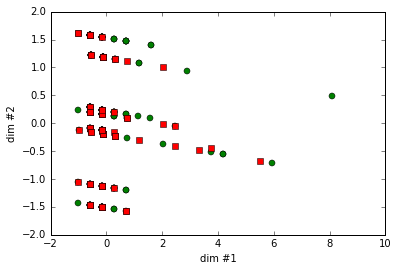

In [8]:
#dim reduction to 2 for visualization - higher dimension plot may help
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
pca.fit(X) 
X_pca = pca.transform(X) 

######## OR #########
#x = data[:,[1,2]] # visualize pairs of dimension

#optional normalization
X_pca = X_pca-np.mean(X_pca,axis=0);
X_pca=X_pca/np.std(X_pca,axis=0);

labels=['sr','og'] #binary label in Y
for i in [0,1]:
  plt.plot(X_pca[Y==i,0],X_pca[Y==i,1],labels[i-1]);
plt.xlabel('dim #1');
plt.ylabel('dim #2');

**Test for skewness in class labels**

In [14]:
label1 = np.sum(Y_train)
print "Number of samples with label 1", label1
print "Total sample size", N
print "Class Distribution of [label0, label1] = [", 1-(label1/N), label1/N, "]"

Number of samples with label 1 93.0
Total sample size 312
Class Distribution of [label0, label1] = [ 0.701923076923 0.298076923077 ]


## Data Preprocessing

Note - We are using only training data from now on <br>
This section should be revisited after getting insights from model training 

**Mean Normalize** <br>

In [15]:
X_train = X_train-np.mean(X_train,axis=0)
X_train=X_train/np.std(X_train,axis=0)

In [16]:
#option 2 - standard scaler
from sklearn.preprocessing import StandardScaler
sk = StandardScaler()
X_train = sk.fit_transform(X_train)

**Dinemsionality Reduction** <br>
Similar to the previous use of PCA to visualize data, here we are using the same technique to improve prediction accuracy by reducing the feature space dimension

In [18]:
from sklearn.decomposition import PCA
components = 3 #set based on your data - can be a hyperparamter to tune in the pipeline
pca = PCA(n_components=components)
pca.fit(X_train)
X_train = pca.transform(X_train)

**Feature Selection**<br>
Another technique to deal with high dimensional feature space

In [28]:
#There are multiple options for these - just an example below
from sklearn import linear_model
from sklearn.feature_selection import RFE

lr = linear_model.LogisticRegression(C=0.2)
rfe = RFE(lr, 3)
rfe = rfe.fit(X_train, Y_train)
X_train_feat = rfe.transform(X_train)

print "Dimension of data after feature selection =", X_train_feat.shape
# summarize the selection of features
print "selected features boolean =", rfe.support_
print "feature ranking =", rfe.ranking_

print "Feature ranking by name -"
for i in range(len(features)):
    print features[i], rfe.ranking_[i]

Dimension of data after feature selection = (250, 3)
selected features boolean = [ True  True  True False]
feature ranking = [1 1 1 2]
Feature ranking by name -
x1 1
x2 1
x3 1
x4 2


**Polynomial Features**<br>
Improves model capacity when there is accuracy gap <br>

In [56]:
from sklearn.preprocessing import PolynomialFeatures

poly = PolynomialFeatures(2, interaction_only = True) #degree 2 and intereaction only
poly.fit(X_train)
X_train = poly.transform(X_train)
X_test = poly.transform(X_test)
print "New dimension with polynomial features =", X_train.shape, X_test.shape

New dimension with polynomial features = (250, 11) (62, 11)


## Model Training

**Decision Trees**<br>
with 5 fold cross validation<br>
no hyperparameter selection

In [33]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import cross_val_score

dt = DecisionTreeClassifier(random_state=0) #set depth
dt.fit(X_train, Y_train)
print "CV accuracy =", np.mean(cross_val_score(dt, X_train, Y_train, cv=5))
print "Feature Importance =", dt.feature_importances_

CV accuracy = 0.628675470188
Feature Importance = [ 0.13042306  0.10467022  0.12969558  0.63521115]


Feature selection for tree based model is different. Example below.

In [ ]:
from sklearn.ensemble import ExtraTreesClassifier

# fit an Extra Trees model to the data
model = ExtraTreesClassifier()
model.fit(X_train, Y_train)
X_train_feat = model.transform(X_train)

# display the relative importance of each attribute
for i in range(len(features)):
    print features[i], model.feature_importances_[i]

**Random Forest**<br>
With hyperparamatere selection

In [40]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score

est_list = [(a+1) for a in range(5)] #hyperparamter range
best_val_acc = 0
best_est = None
best_rf = None

for est in est_list:
    rf = RandomForestClassifier(random_state=0, n_estimators=est)
    val_acc = np.mean(cross_val_score(rf, X_train, Y_train, cv=5))
    if val_acc > best_val_acc:
        best_rf = rf
        best_val_acc = val_acc
        best_est = est
                          
        print "n_est =", best_est, "CV acc =", best_val_acc

n_est = 1 CV acc = 0.608829131653
n_est = 2 CV acc = 0.633315726291
n_est = 3 CV acc = 0.636757102841


**Logistic Regression**<br>
With hyperparamatere selection and feature selection with polynomial features

In [42]:
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import RFE
from sklearn.model_selection import cross_val_score

C_list = [(a+1)*0.1 for a in range(10)] #hyperparameter
num_feat_list = [(a+1) for a in range(22)] #feature selection parameter
best_val_acc = 0
best_num_feat = None
best_C = None
best_lr = None

for C in C_list:
    lr = LogisticRegression(C=C)
    for num_feat in num_feat_list:
        rfe = RFE(lr, num_feat)
        rfe = rfe.fit(X_train, Y_train)
        X_train_feat = X_train[:,rfe.support_]
        val_acc = np.mean(cross_val_score(lr, X_train_feat, Y_train, cv=5))
        if val_acc > best_val_acc:
            best_lr = lr
            best_num_feat = num_feat
            best_val_acc = val_acc
            best_C = C
                          
            print "C =", best_C, "num_feat", best_num_feat, "CV acc =", best_val_acc

C = 0.1 num_feat 1 CV acc = 0.628041616647
C = 0.1 num_feat 6 CV acc = 0.640600240096


**Support Vector Machine (SVM)** <br>
With hyperparamatere selection and feature selection with polynomial features

In [58]:
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score
from sklearn.feature_selection import RFE

gamma_list = [(a+1)*0.03 for a in range(40)] #hyperparameter
num_feat_list = [(a+1) for a in range(22)] #feature selection parameter
best_val_acc = 0
best_num_feat = None
best_gamma = None
best_svc = None
lr = LogisticRegression(C=0.5)

for gamma in gamma_list:
    svc = SVC(gamma=gamma)
    for num_feat in num_feat_list:
        rfe = RFE(lr, num_feat)
        rfe = rfe.fit(X_train, Y_train)
        X_train_feat = X_train[:,rfe.support_]
        val_acc = np.mean(cross_val_score(svc, X_train_feat, Y_train, cv=5))
        if val_acc > best_val_acc:
            best_svc = svc
            best_num_feat = num_feat
            best_val_acc = val_acc
            best_gamma = gamma
                          
            print "gamma =", best_gamma, "num_feat", best_num_feat, "CV acc =", best_val_acc

gamma = 0.03 num_feat 1 CV acc = 0.628041616647
gamma = 0.51 num_feat 10 CV acc = 0.628675470188
gamma = 0.54 num_feat 10 CV acc = 0.636518607443
gamma = 0.57 num_feat 10 CV acc = 0.64044017607
gamma = 0.69 num_feat 10 CV acc = 0.644521808723
gamma = 0.78 num_feat 10 CV acc = 0.656443377351


## Testing Model Generalizability

Example test for SVM

In [62]:
lr = LogisticRegression(C=0.5)
rfe = RFE(lr, 3) #example best feature
rfe = rfe.fit(X_train, Y_train)
X_train_feat = X_train[:,rfe.support_]
svc = SVC(gamma=0.78) #best hyperparameter chosen from model selection
svc.fit(X_train_feat, Y_train)
X_test_feat = X_test[:,rfe.support_]
Y_pred = svc.predict(X_test_feat)
print "SVM Test accuracy =", np.mean(Y_pred == Y_test)

Test accuracy = 0.612903225806


Example test for LR

In [68]:
lr = LogisticRegression(C=0.1) #best hyperparameter chosen from model selection
rfe = RFE(lr, 17) #example best feature
rfe = rfe.fit(X_train, Y_train)
X_train_feat = X_train[:,rfe.support_]
lr.fit(X_train, Y_train)
Y_pred = lr.predict(X_test)
print "LR Test accuracy =", np.mean(Y_pred == Y_test)

LR Test accuracy = 0.516129032258


**Testing other metrics** <br>
There should be a library in scikit for this :) Naive implementation below

In [71]:
POS_LABEL = 1
NEG_LABEL = 0
scores = {'tp':0,'tn':0,'fp':0,'fn':0}
for i,p in enumerate(Y_pred):
    if Y_train[i] == POS_LABEL:
        if p == POS_LABEL:
            scores['tp'] += 1
        else:
            scores['fn'] += 1
    else:
        if p == POS_LABEL:
            scores['fp'] += 1
        else:
            scores['tn'] += 1
                        
precision = scores['tp'] / (scores['tp'] + scores['fp'])
recall = scores['tp'] / (scores['tp'] + scores['fn'])
print "precision=", precision
print "recall=", recall

precision= 0.375
recall= 0.111111111111


## Post Pipeline Reflections
To help inform next steps

Question 1 - **Will accuracy improve with more training data ?**<br>
helper code borrowed from scikit

In [72]:
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.model_selection import learning_curve
from sklearn.model_selection import ShuffleSplit
from sklearn.model_selection import StratifiedShuffleSplit

def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None,
                        n_jobs=1, train_sizes=np.linspace(.1, 1.0, 5)):
    """
    Generate a simple plot of the test and training learning curve.

    Parameters
    ----------
    estimator : object type that implements the "fit" and "predict" methods
        An object of that type which is cloned for each validation.

    title : string
        Title for the chart.

    X : array-like, shape (n_samples, n_features)
        Training vector, where n_samples is the number of samples and
        n_features is the number of features.

    y : array-like, shape (n_samples) or (n_samples, n_features), optional
        Target relative to X for classification or regression;
        None for unsupervised learning.

    ylim : tuple, shape (ymin, ymax), optional
        Defines minimum and maximum yvalues plotted.

    cv : int, cross-validation generator or an iterable, optional
        Determines the cross-validation splitting strategy.
        Possible inputs for cv are:
          - None, to use the default 3-fold cross-validation,
          - integer, to specify the number of folds.
          - An object to be used as a cross-validation generator.
          - An iterable yielding train/test splits.

        For integer/None inputs, if ``y`` is binary or multiclass,
        :class:`StratifiedKFold` used. If the estimator is not a classifier
        or if ``y`` is neither binary nor multiclass, :class:`KFold` is used.

        Refer :ref:`User Guide <cross_validation>` for the various
        cross-validators that can be used here.

    n_jobs : integer, optional
        Number of jobs to run in parallel (default 1).
    """
    plt.figure()
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")

    plt.legend(loc="best")
    return plt


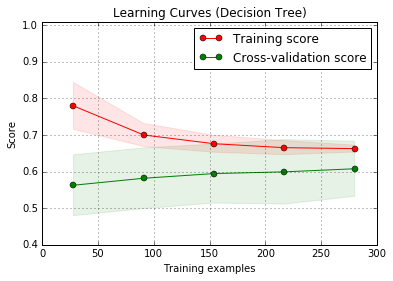

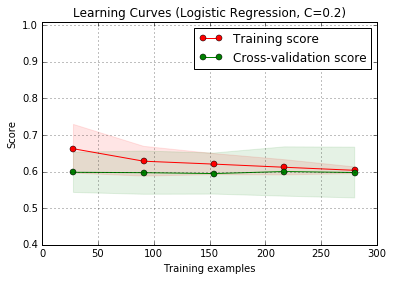

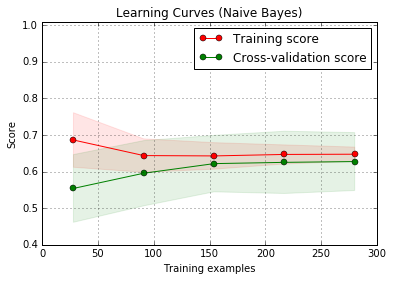

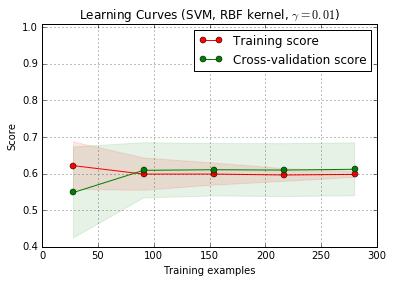

In [73]:
title = "Learning Curves (Decision Tree)"
# Cross validation with 100 iterations to get smoother mean test and train
# score curves, each time with 20% data randomly selected as a validation set.
cv = ShuffleSplit(n_splits=100, test_size=0.10, random_state=0)

estimator = DecisionTreeClassifier(max_depth=3)
plot_learning_curve(estimator, title, X, Y, ylim=(0.4, 1.01), cv=cv, n_jobs=4)

title = "Learning Curves (Logistic Regression, C=0.2)"
# Cross validation with 100 iterations to get smoother mean test and train
# score curves, each time with 20% data randomly selected as a validation set.
cv = StratifiedShuffleSplit(n_splits=100, test_size=0.10, random_state=0)

estimator = LogisticRegression(C=0.2)
plot_learning_curve(estimator, title, X, Y, ylim=(0.4, 1.01), cv=cv, n_jobs=4)


title = "Learning Curves (Naive Bayes)"
# Cross validation with 100 iterations to get smoother mean test and train
# score curves, each time with 20% data randomly selected as a validation set.
cv = ShuffleSplit(n_splits=100, test_size=0.10, random_state=0)

estimator = GaussianNB()
plot_learning_curve(estimator, title, X, Y, ylim=(0.4, 1.01), cv=cv, n_jobs=4)

title = "Learning Curves (SVM, RBF kernel, $\gamma=0.01$)"
# SVC is more expensive so we do a lower number of CV iterations:
cv = ShuffleSplit(n_splits=100, test_size=0.10, random_state=0)
estimator = SVC(gamma=0.01)
plot_learning_curve(estimator, title, X, Y, (0.4, 1.01), cv=cv, n_jobs=4)

plt.show()